## IMPORTING LIBRARIES ##

In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import pandas as pd
import seaborn as sns
import pathlib as Path
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit



# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


## LOADING THE TRAIN DATA

In [23]:
df = pd.read_csv('../input/train.csv')
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


In [25]:
df = df[df.passenger_count >= 1]
df = df[df.trip_duration >= 120]
df = df[df.trip_duration <= 7200]

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


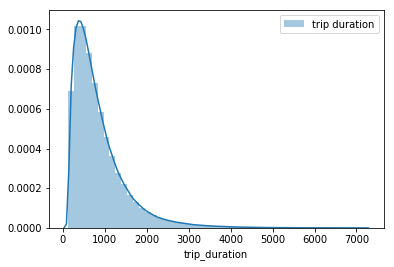

In [26]:
sns.distplot(df['trip_duration'], label='trip duration')
plt.legend();


## Creating addotional columns from pickup datetime

In [27]:
df['pickup_year'] = df['pickup_datetime'].dt.year
df['pickup_month'] = df['pickup_datetime'].dt.month
df['pickup_day'] = df['pickup_datetime'].dt.day
df['pickup_weekday'] = df['pickup_datetime'].dt.weekday
df['hour'] = df['pickup_datetime'].dt.hour
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_year,pickup_month,pickup_day,pickup_weekday,hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016,3,14,0,17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016,6,12,6,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016,1,19,1,11
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016,4,6,2,19
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016,3,26,5,13


## Creating addotional columns from dropoff datetime

In [28]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_year,pickup_month,pickup_day,pickup_weekday,hour
count,1.428561e+06,1.428561e+06,1.428561e+06,1.428561e+06,1.428561e+06,1.428561e+06,1.428561e+06,1428561.0,1.428561e+06,1.428561e+06,1.428561e+06,1.428561e+06
mean,1.535146e+00,1.666123e+00,-7.397362e+01,4.075088e+01,-7.397354e+01,4.075176e+01,8.509061e+02,2016.0,3.517492e+00,1.550550e+01,3.047689e+00,1.362631e+01
std,4.987634e-01,1.314809e+00,7.100518e-02,3.260896e-02,7.074141e-02,3.570765e-02,6.518445e+02,0.0,1.681012e+00,8.703311e+00,1.952779e+00,6.390373e+00
min,1.000000e+00,1.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.200000e+02,2016.0,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399190e+01,4.073731e+01,-7.399134e+01,4.073579e+01,4.110000e+02,2016.0,2.000000e+00,8.000000e+00,1.000000e+00,9.000000e+00
50%,2.000000e+00,1.000000e+00,-7.398180e+01,4.075401e+01,-7.397980e+01,4.075447e+01,6.730000e+02,2016.0,4.000000e+00,1.500000e+01,3.000000e+00,1.400000e+01
75%,2.000000e+00,2.000000e+00,-7.396757e+01,4.076827e+01,-7.396318e+01,4.076969e+01,1.084000e+03,2016.0,5.000000e+00,2.300000e+01,5.000000e+00,1.900000e+01
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,7.191000e+03,2016.0,6.000000e+00,3.100000e+01,6.000000e+00,2.300000e+01


In [29]:
selected_columns = ['passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 
                    'dropoff_latitude', 'pickup_year',
                    'pickup_month', 'pickup_day', 'hour', 'pickup_weekday']
X = df[selected_columns]
y = df['trip_duration']
X.shape, y.shape


((1428561, 10), (1428561,))

## Shuffleling the data 

In [30]:
cv = ShuffleSplit(1, test_size=0.01, train_size=0.02, random_state=0)

## Categorising hours to avoid numerics

## Training the data

In [31]:
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor()
losses = cross_val_score(rf, X, y, cv=cv, scoring='neg_mean_squared_log_error')
np.sqrt(- losses.mean())


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.4043800263505348

In [32]:
rf.fit(X, y)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

## Loading the test file for prediction

In [33]:
df_test = pd.read_csv('../input/test.csv')
df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'])
df_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [34]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
id                    625134 non-null object
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null datetime64[ns]
passenger_count       625134 non-null int64
pickup_longitude      625134 non-null float64
pickup_latitude       625134 non-null float64
dropoff_longitude     625134 non-null float64
dropoff_latitude      625134 non-null float64
store_and_fwd_flag    625134 non-null object
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 42.9+ MB


In [35]:
df_test['pickup_year'] = df_test['pickup_datetime'].dt.year
df_test['pickup_month'] = df_test['pickup_datetime'].dt.month
df_test['pickup_day'] = df_test['pickup_datetime'].dt.day
df_test['pickup_weekday'] = df_test['pickup_datetime'].dt.weekday
df_test['hour'] = df_test['pickup_datetime'].dt.hour
df_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_year,pickup_month,pickup_day,pickup_weekday,hour
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,2016,6,30,3,23
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,2016,6,30,3,23
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,2016,6,30,3,23
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,2016,6,30,3,23
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,2016,6,30,3,23


In [36]:
X_test = df_test[selected_columns]

In [37]:
y_pred = rf.predict(X_test)
y_pred.mean()

851.5105414896186

## LOADING THE SUBMISSION TIME

In [38]:
submission = pd.read_csv('../input/sample_submission.csv') 
submission.head()

,id,trip_duration
0,id3004672,959
1,id3505355,959
2,id1217141,959
3,id2150126,959
4,id1598245,959


In [39]:
submission['trip_duration'] = y_pred
submission.head()

,id,trip_duration
0,id3004672,806.3
1,id3505355,557.1
2,id1217141,423.5
3,id2150126,992.1
4,id1598245,406.6


In [40]:
submission.describe()

,trip_duration
count,625134.000000
mean,851.510541
std,592.856024
min,129.600000
25%,444.900000
50%,688.200000
75%,1070.500000
max,6118.400000


In [41]:
submission.to_csv('submission.csv', index=False)


In [42]:
!ls

__notebook_source__.ipynb  submission.csv
